In [2]:
import pandas as pd
train = pd.read_feather('Feathers/processed_train_data.feather')
train.head()

,text,label
0,reader mail sc ruling alimony supreme court ex...,0
1,niqaab elephant courtroom say uk judge person ...,0
2,grandparent honoured staff student global publ...,0
3,guardian quick crossword convinced know pay news,0
4,fisherman strike country boat fisherman pamban...,1


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df = 0.75, min_df = 0.01)),
    ('rus', RandomUnderSampler(sampling_strategy = 0.5)),
    ('smt', SMOTE()),
    ('tmk', TomekLinks()),
    ('clf', MultinomialNB()),
])

parameters = {
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams, bigrams or trigrams
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.001, 0.01, 0.1, 1.0),
    'clf__fit_prior': (True, False),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1_macro')
grid_search.fit(train.text, train.label)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.2s


Best score: 0.816
Best parameters set:
	clf__alpha: 0.001
	clf__fit_prior: False
	tfidf__ngram_range: (1, 1)
	tfidf__norm: 'l2'
	tfidf__smooth_idf: True
	tfidf__use_idf: False


[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   52.9s finished


In [4]:
test = pd.read_feather('Feathers/processed_test_data.feather')
test.head()

,text,label
0,ranipet student top vellore district special c...,0
1,science camp schoolchildren science camp merit...,0
2,bahutule retires day th birthday vidarbha skip...,0
3,heavy rain likely day woman reported missing f...,0
4,police complaint caste hindu dalit resident pa...,0


              precision    recall  f1-score   support

           0       0.99      0.90      0.94       456
           1       0.76      0.98      0.86       150

    accuracy                           0.92       606
   macro avg       0.88      0.94      0.90       606
weighted avg       0.94      0.92      0.92       606



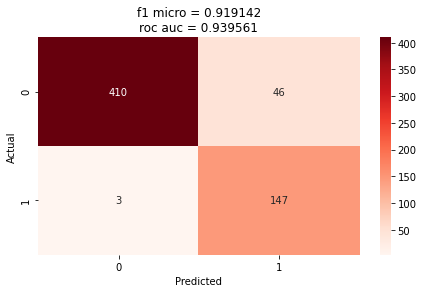

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_pred = grid_search.predict(train.text)
print(classification_report(train.label, y_pred))

conf_matrix = confusion_matrix(train.label, y_pred)
plt.figure(figsize=(7.2,4))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            xticklabels=[0, 1], 
            yticklabels=[0, 1],
            cmap="Reds",)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('f1 micro = %f\nroc auc = %f' %(f1_score(train.label, y_pred, average='micro'), roc_auc_score(train.label, y_pred)))
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       153
           1       0.70      0.76      0.73        50

    accuracy                           0.86       203
   macro avg       0.81      0.83      0.82       203
weighted avg       0.87      0.86      0.86       203



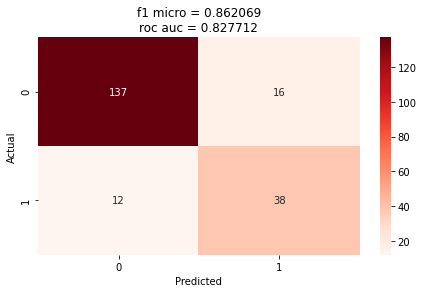

In [6]:
y_pred = grid_search.predict(test.text)
print(classification_report(test.label, y_pred))
conf_matrix = confusion_matrix(test.label, y_pred)
plt.figure(figsize=(7.2,4))
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            xticklabels=[0, 1], 
            yticklabels=[0, 1],
            cmap="Reds",)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('f1 micro = %f\nroc auc = %f' %(f1_score(test.label, y_pred, average='micro'), roc_auc_score(test.label, y_pred)))
plt.show()

In [7]:
d = {
    'Model': 'Multinomial Naïve Bayes',
    'Training Set F1': f1_score(train.label, grid_search.predict(train.text), average='micro'),
    'Training Set ROC AUC': roc_auc_score(train.label, grid_search.predict(train.text)),
    'Test Set F1': f1_score(test.label, y_pred, average='micro'),
    'Test Set ROC AUC': roc_auc_score(test.label, y_pred)
}

df_models_mnb = pd.DataFrame(d, index=[0])
df_models_mnb

,Model,Training Set F1,Training Set ROC AUC,Test Set F1,Test Set ROC AUC
0,Multinomial Naïve Bayes,0.919142,0.939561,0.862069,0.827712


In [8]:
df_models_mnb.to_feather('Feathers/Models/mnb.feather')